# NOT Using ImageNet-1000
- ImageNet-1000 데이터셋 전부가 아닌 맨앞의 클래스 5개만 이용한 결과 (run_name: `2021-06-15-14-10-25_YOLOv1Pretrainer_LR0.000300_BS064_WORKERS16_EPOCHS200_GPU`)
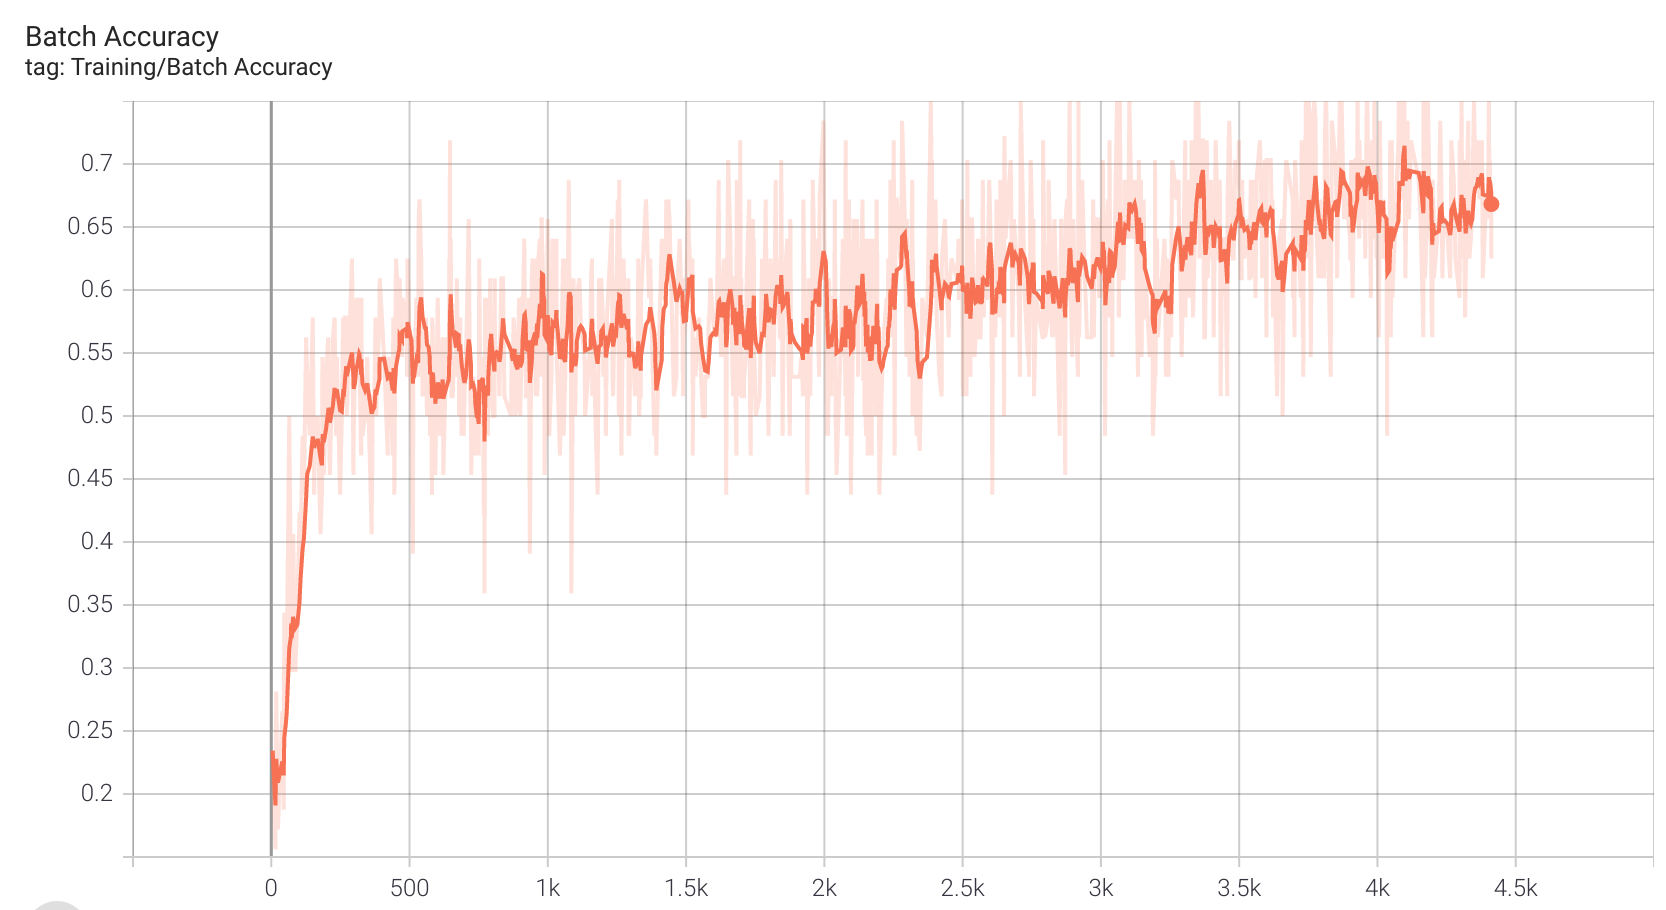
- Learning rate `0.003`을 이용하였음
- Max Accuracy: 0.7969, Epoch ~44에서 달성

# Not using ImageNet-1000 v2
- 이번에는 10개의 클래스만 이용한 결과 (run_name: `2021-06-15-14-29-31_TenClasses_LR0.000300_BS064_WORKERS16_EPOCHS200_GPU`)
- 동일하게 LR=`0.0003`을 이용하였음

## Loss
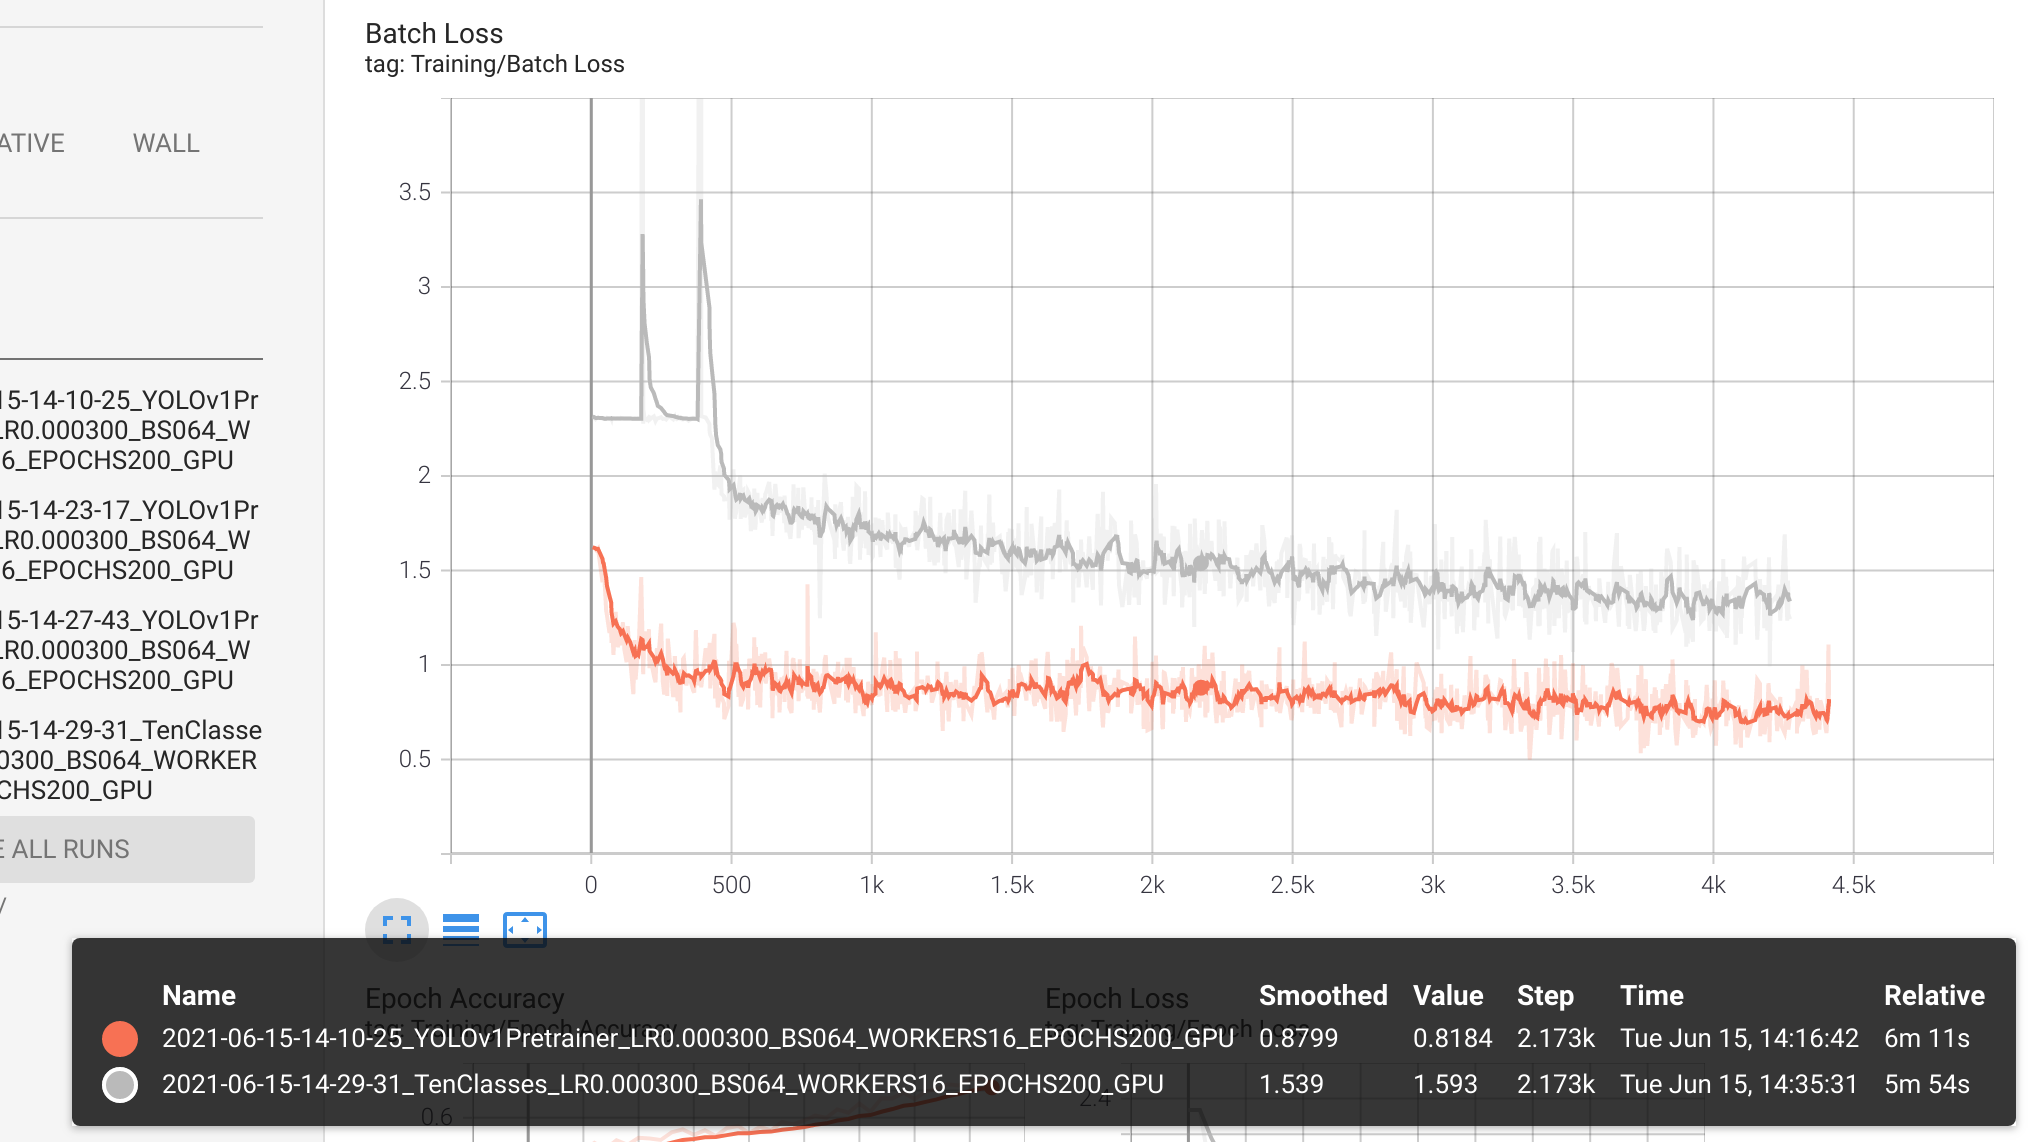
- 회색 부분에 해당하는 그래프임
- 초반부에 Flat한 부분 뒤로 ~500batch 뒤에 수렴하기 시작함

## Accuracy
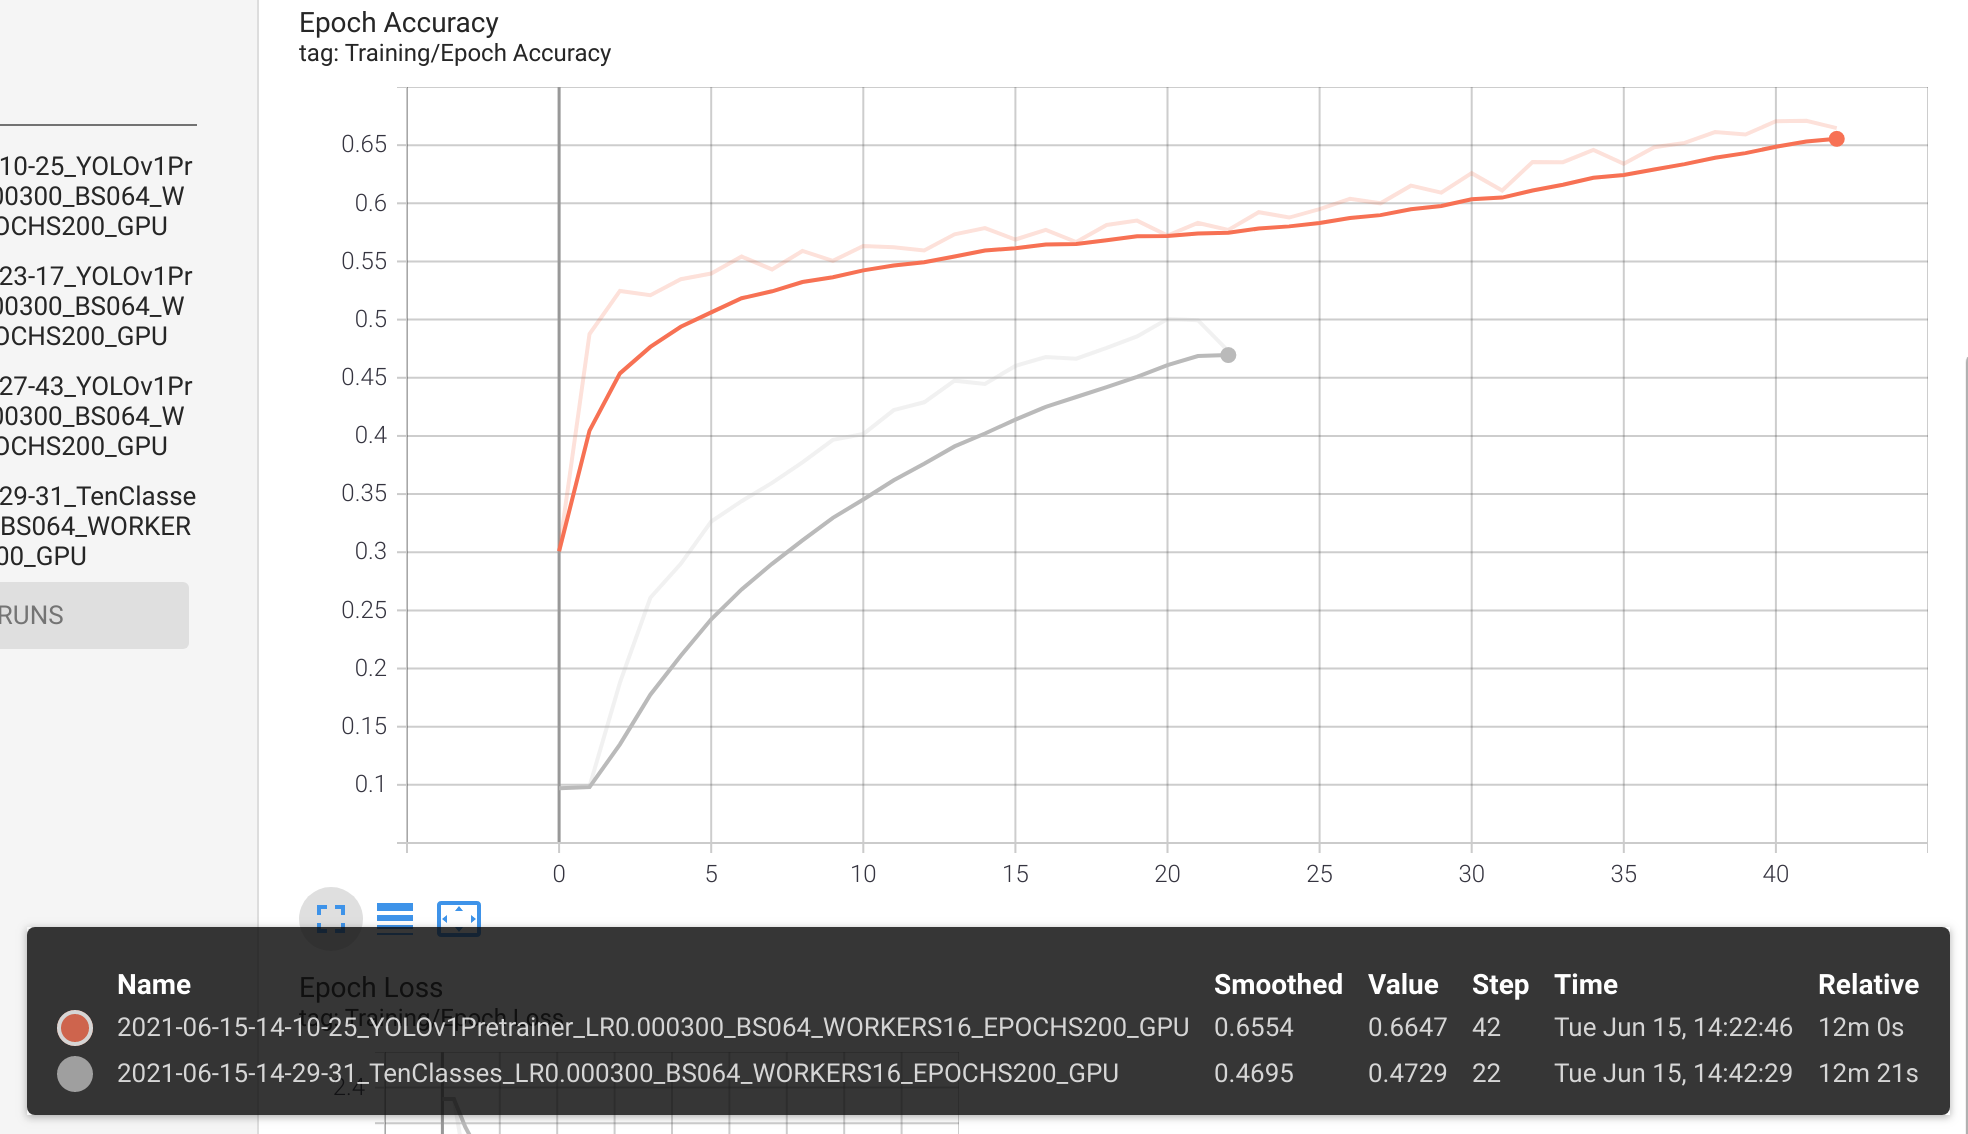
- 전체적으로 올라가고 있는 것을 확인할 수 있음 (25에폭 기준 0.5 달성)

# with AMP
- run_name: `2021-06-15-14-45-29_FiveClass-AMP_LR0.000300_BS064_WORKERS16_EPOCHS200_GPU`
- LR 0.0003, 5개 클래스 분류에서 AMP와 GradScaler를 활성화 한 뒤 학습 진행해봄
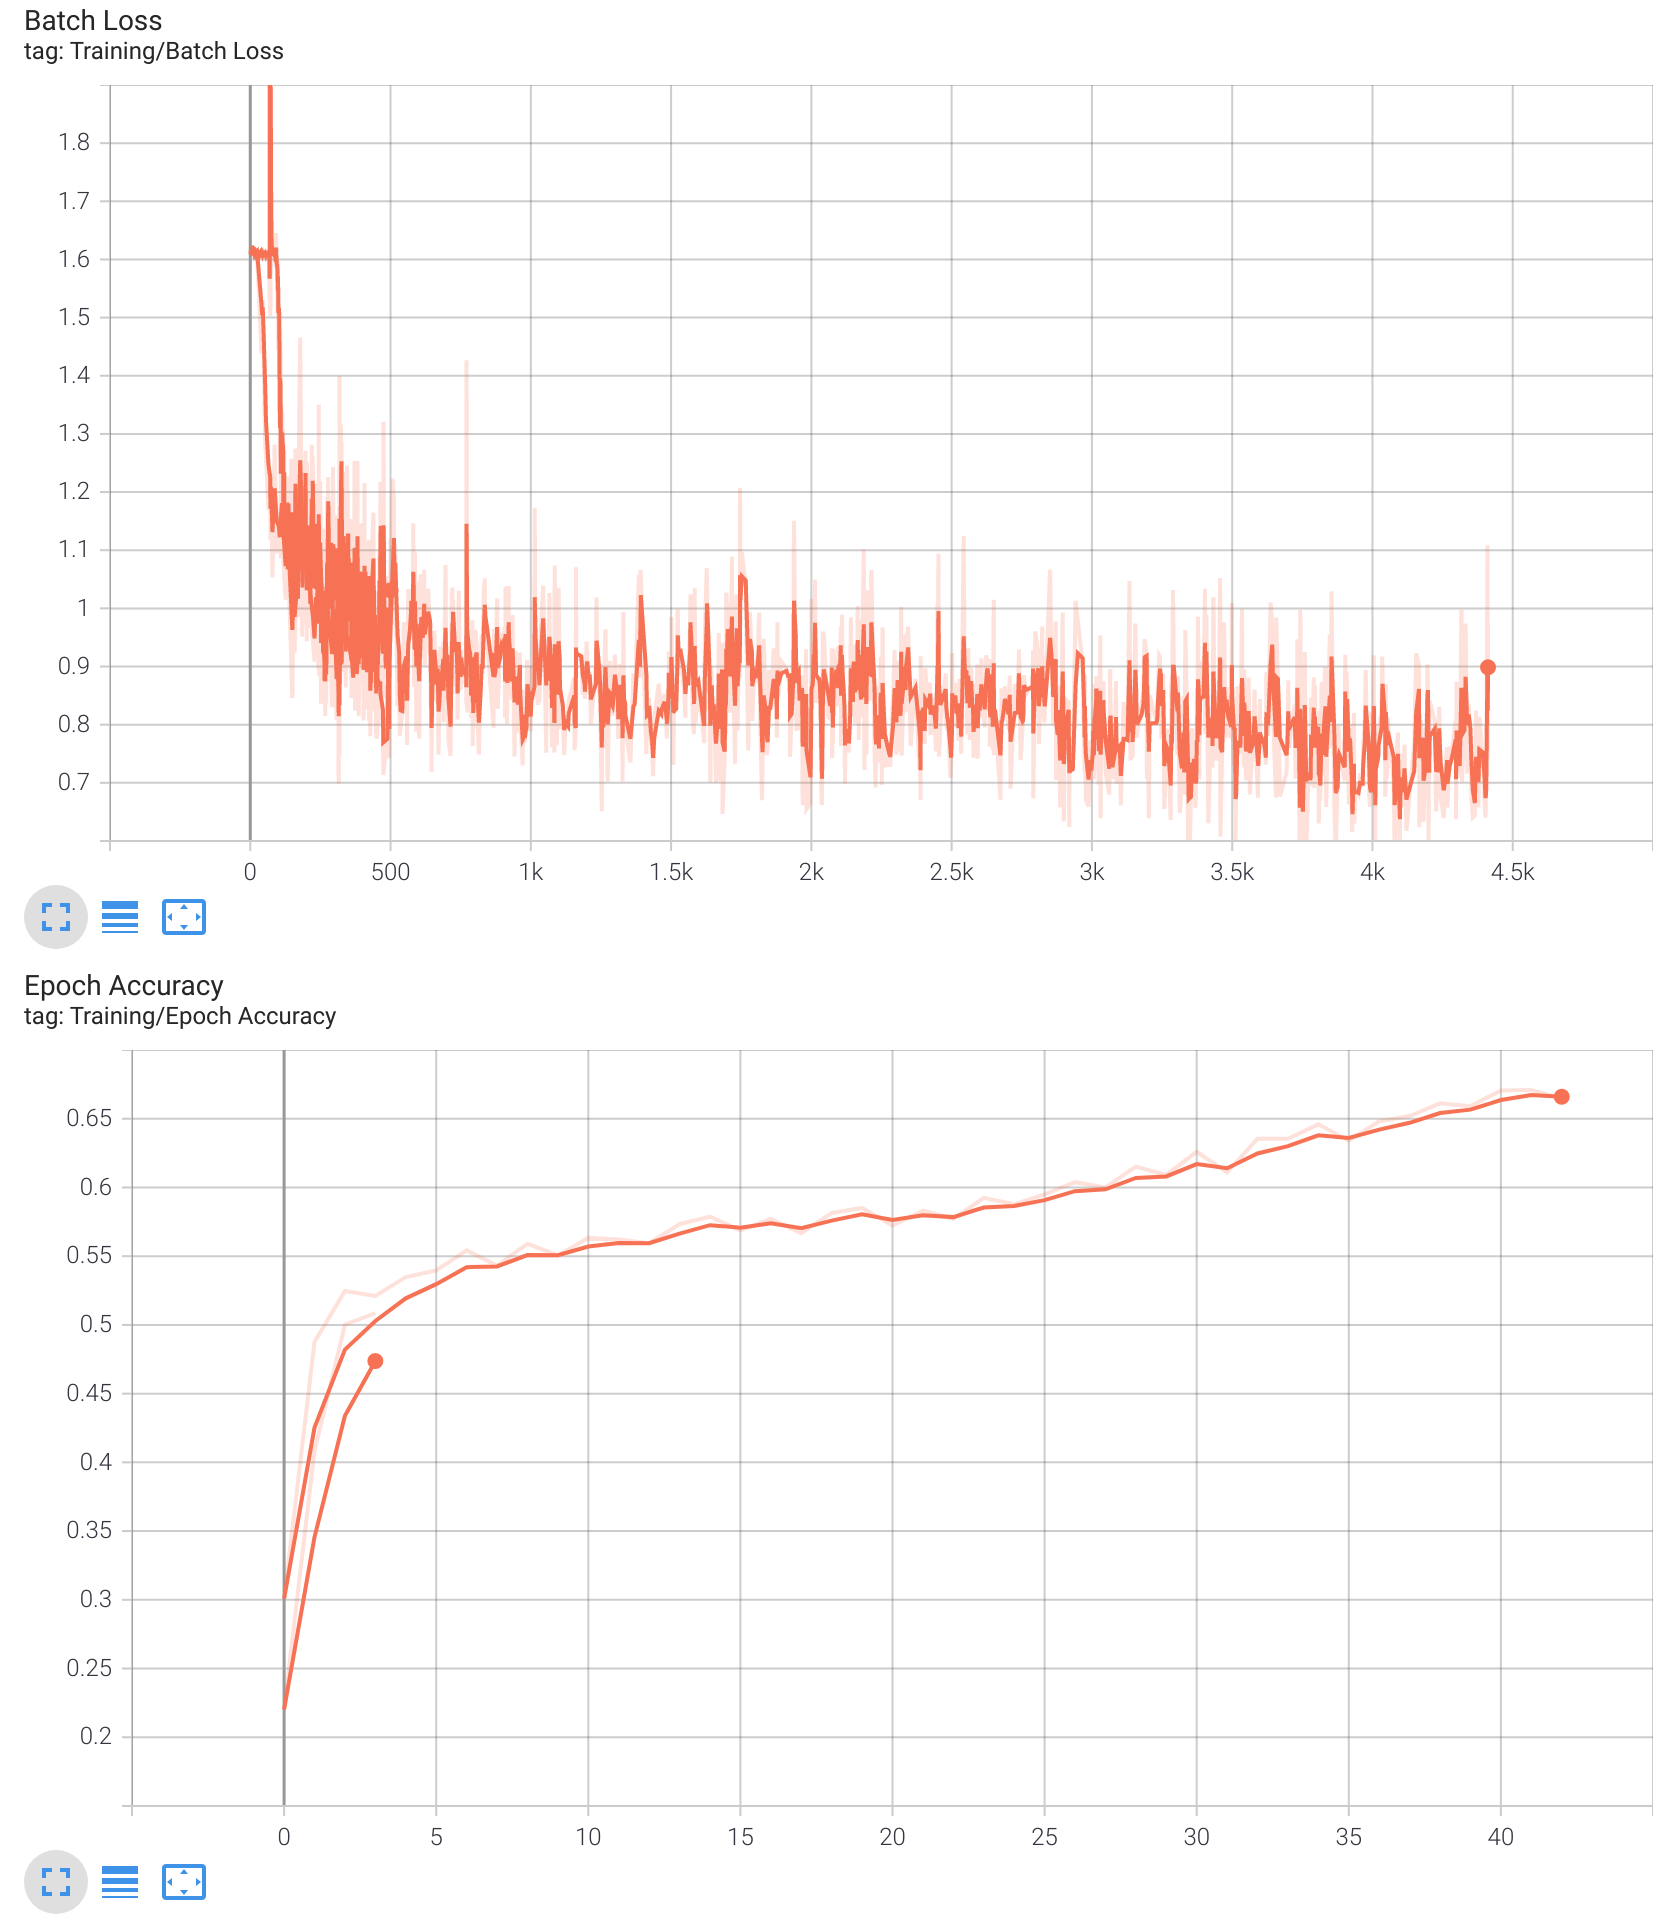
- 결론: 일단 5개 클래스 분류에서는 두개 사이에 차이는 없는 듯함

# with AMP, 2nd try
- run_name: `2021-06-15-14-48-27_FiveClass-AMP_LR0.000300_BS064_WORKERS16_EPOCHS200_GPU`
- 같은 환경에서 10개 클래스 분류 문제로 바꿔서 학습해봄
- 한 에폭당 거의 40초정도로 상당히 빨라짐을 확인함
- 수렴이 비슷한 양상으로 진행됨
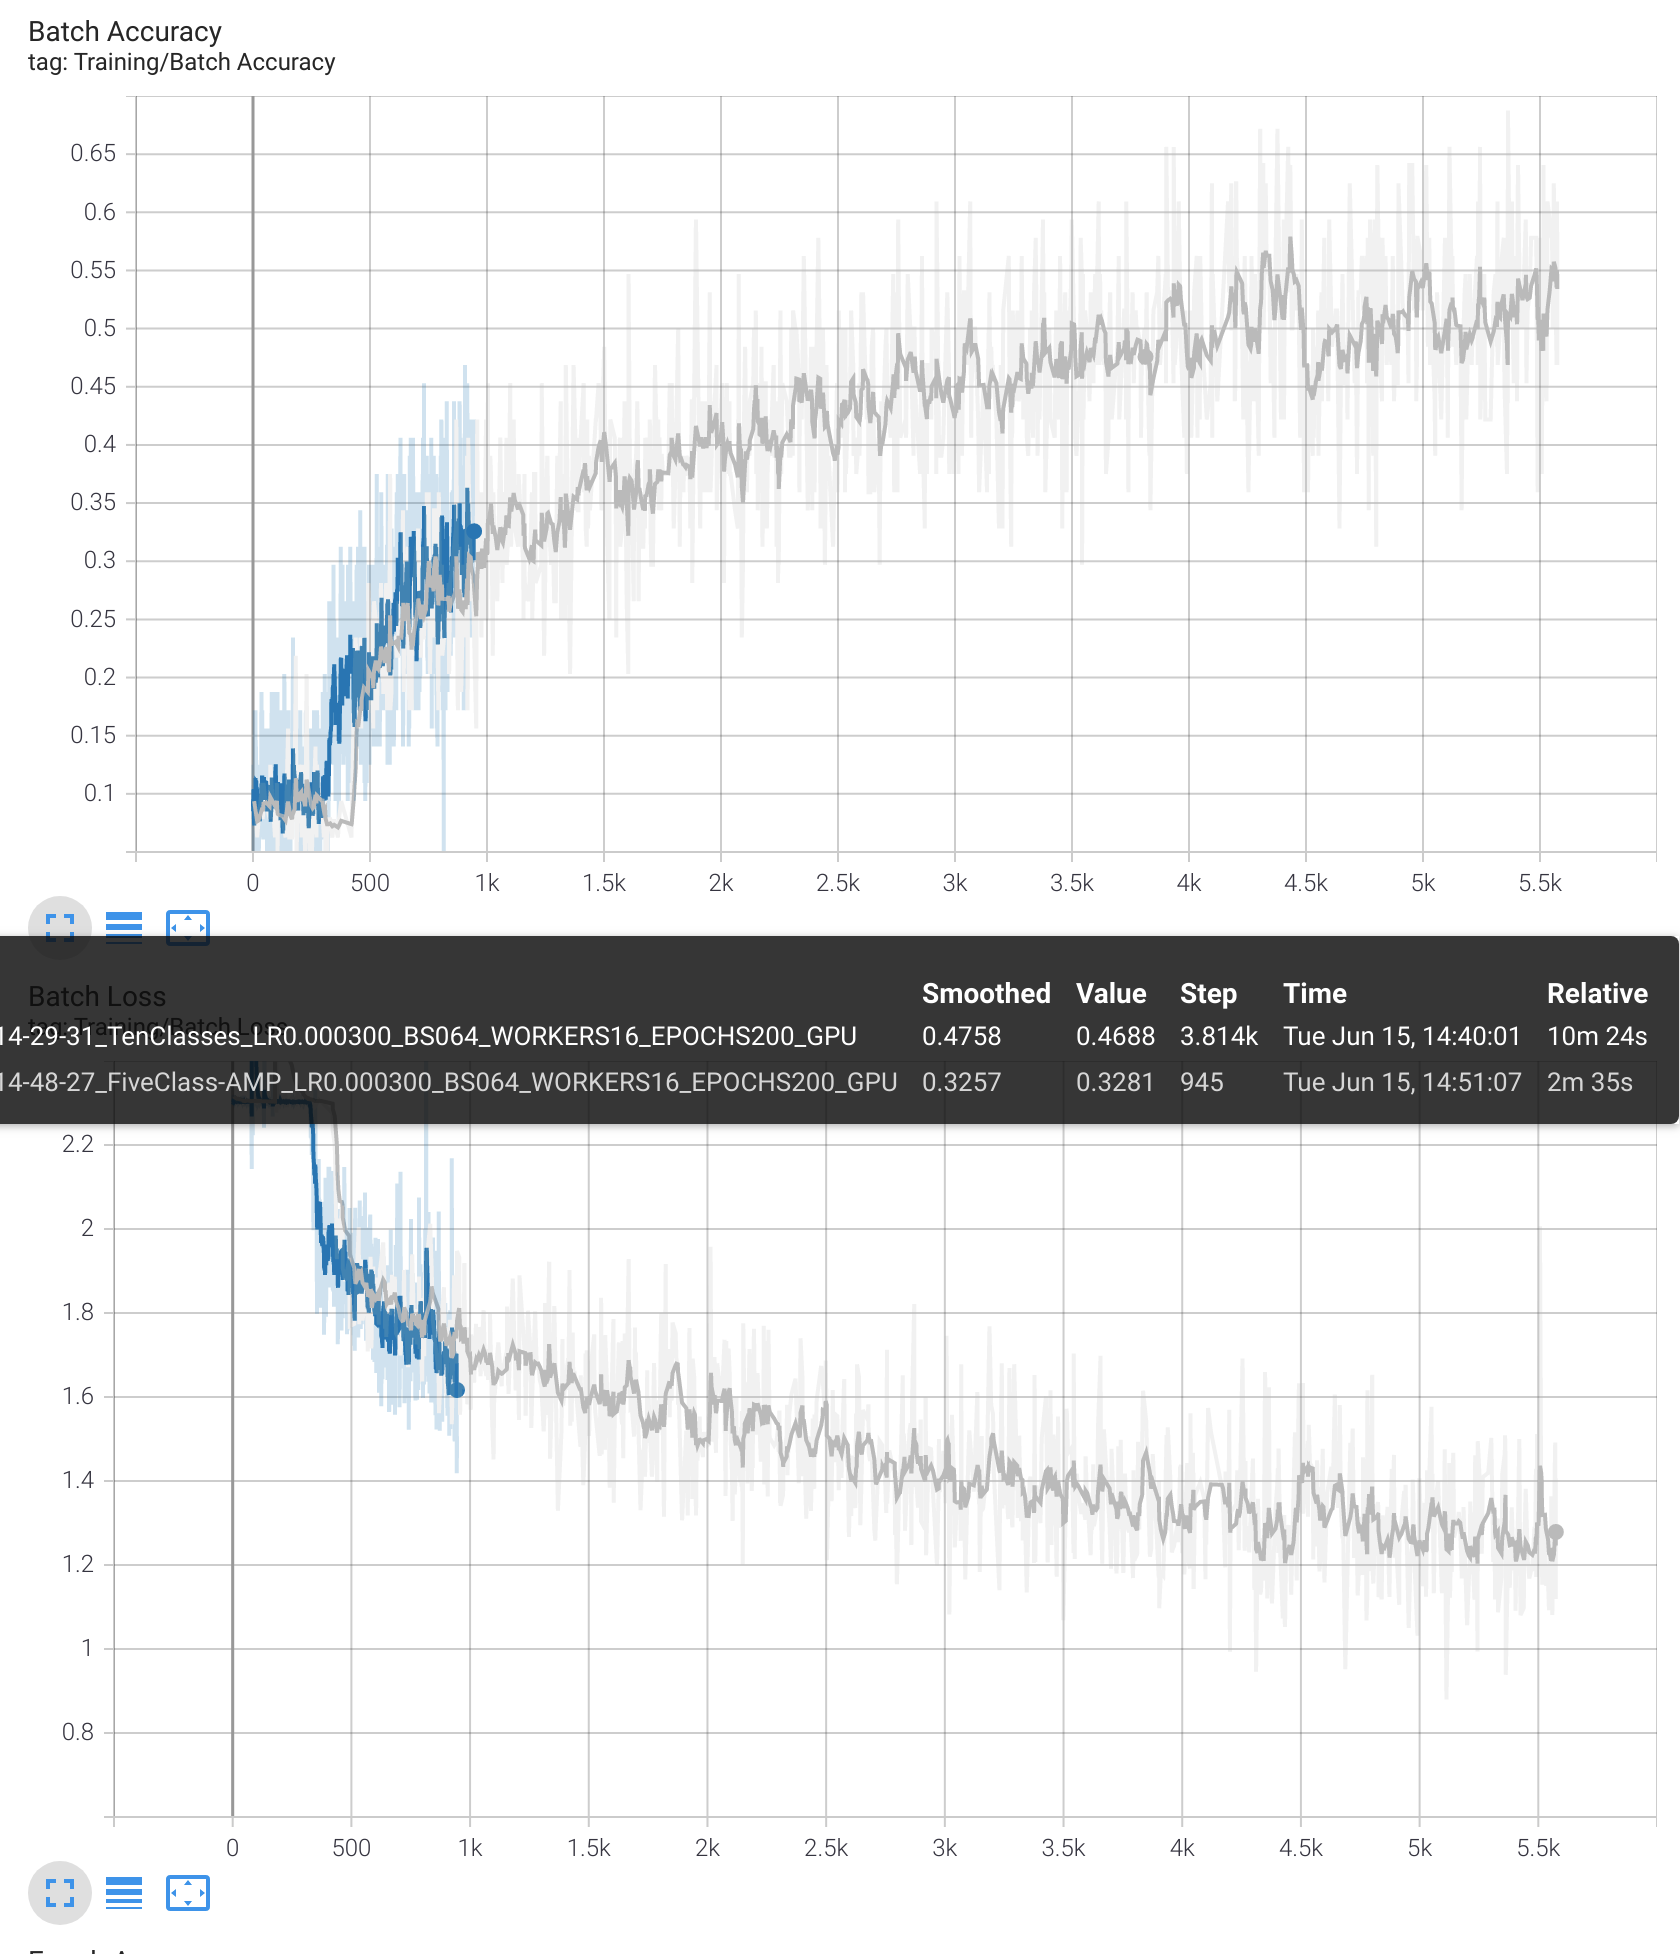
- 결론: 10개 클래스 분류에서도 두개 사이의 차이가 거의 없고 성능이 향상됨 (파란색이 AMP, 회색이 일반)


# with AMP!
- 이제 AMP를 적극적으로 활용해보자
- 이번에는 50개 클래스를 AMP와 LR=`0.0003`을 이용하여 시도해본다.
- run_name: `2021-06-15-14-53-15_FiveClass-AMP_LR0.000300_BS064_WORKERS16_EPOCHS200_GPU`
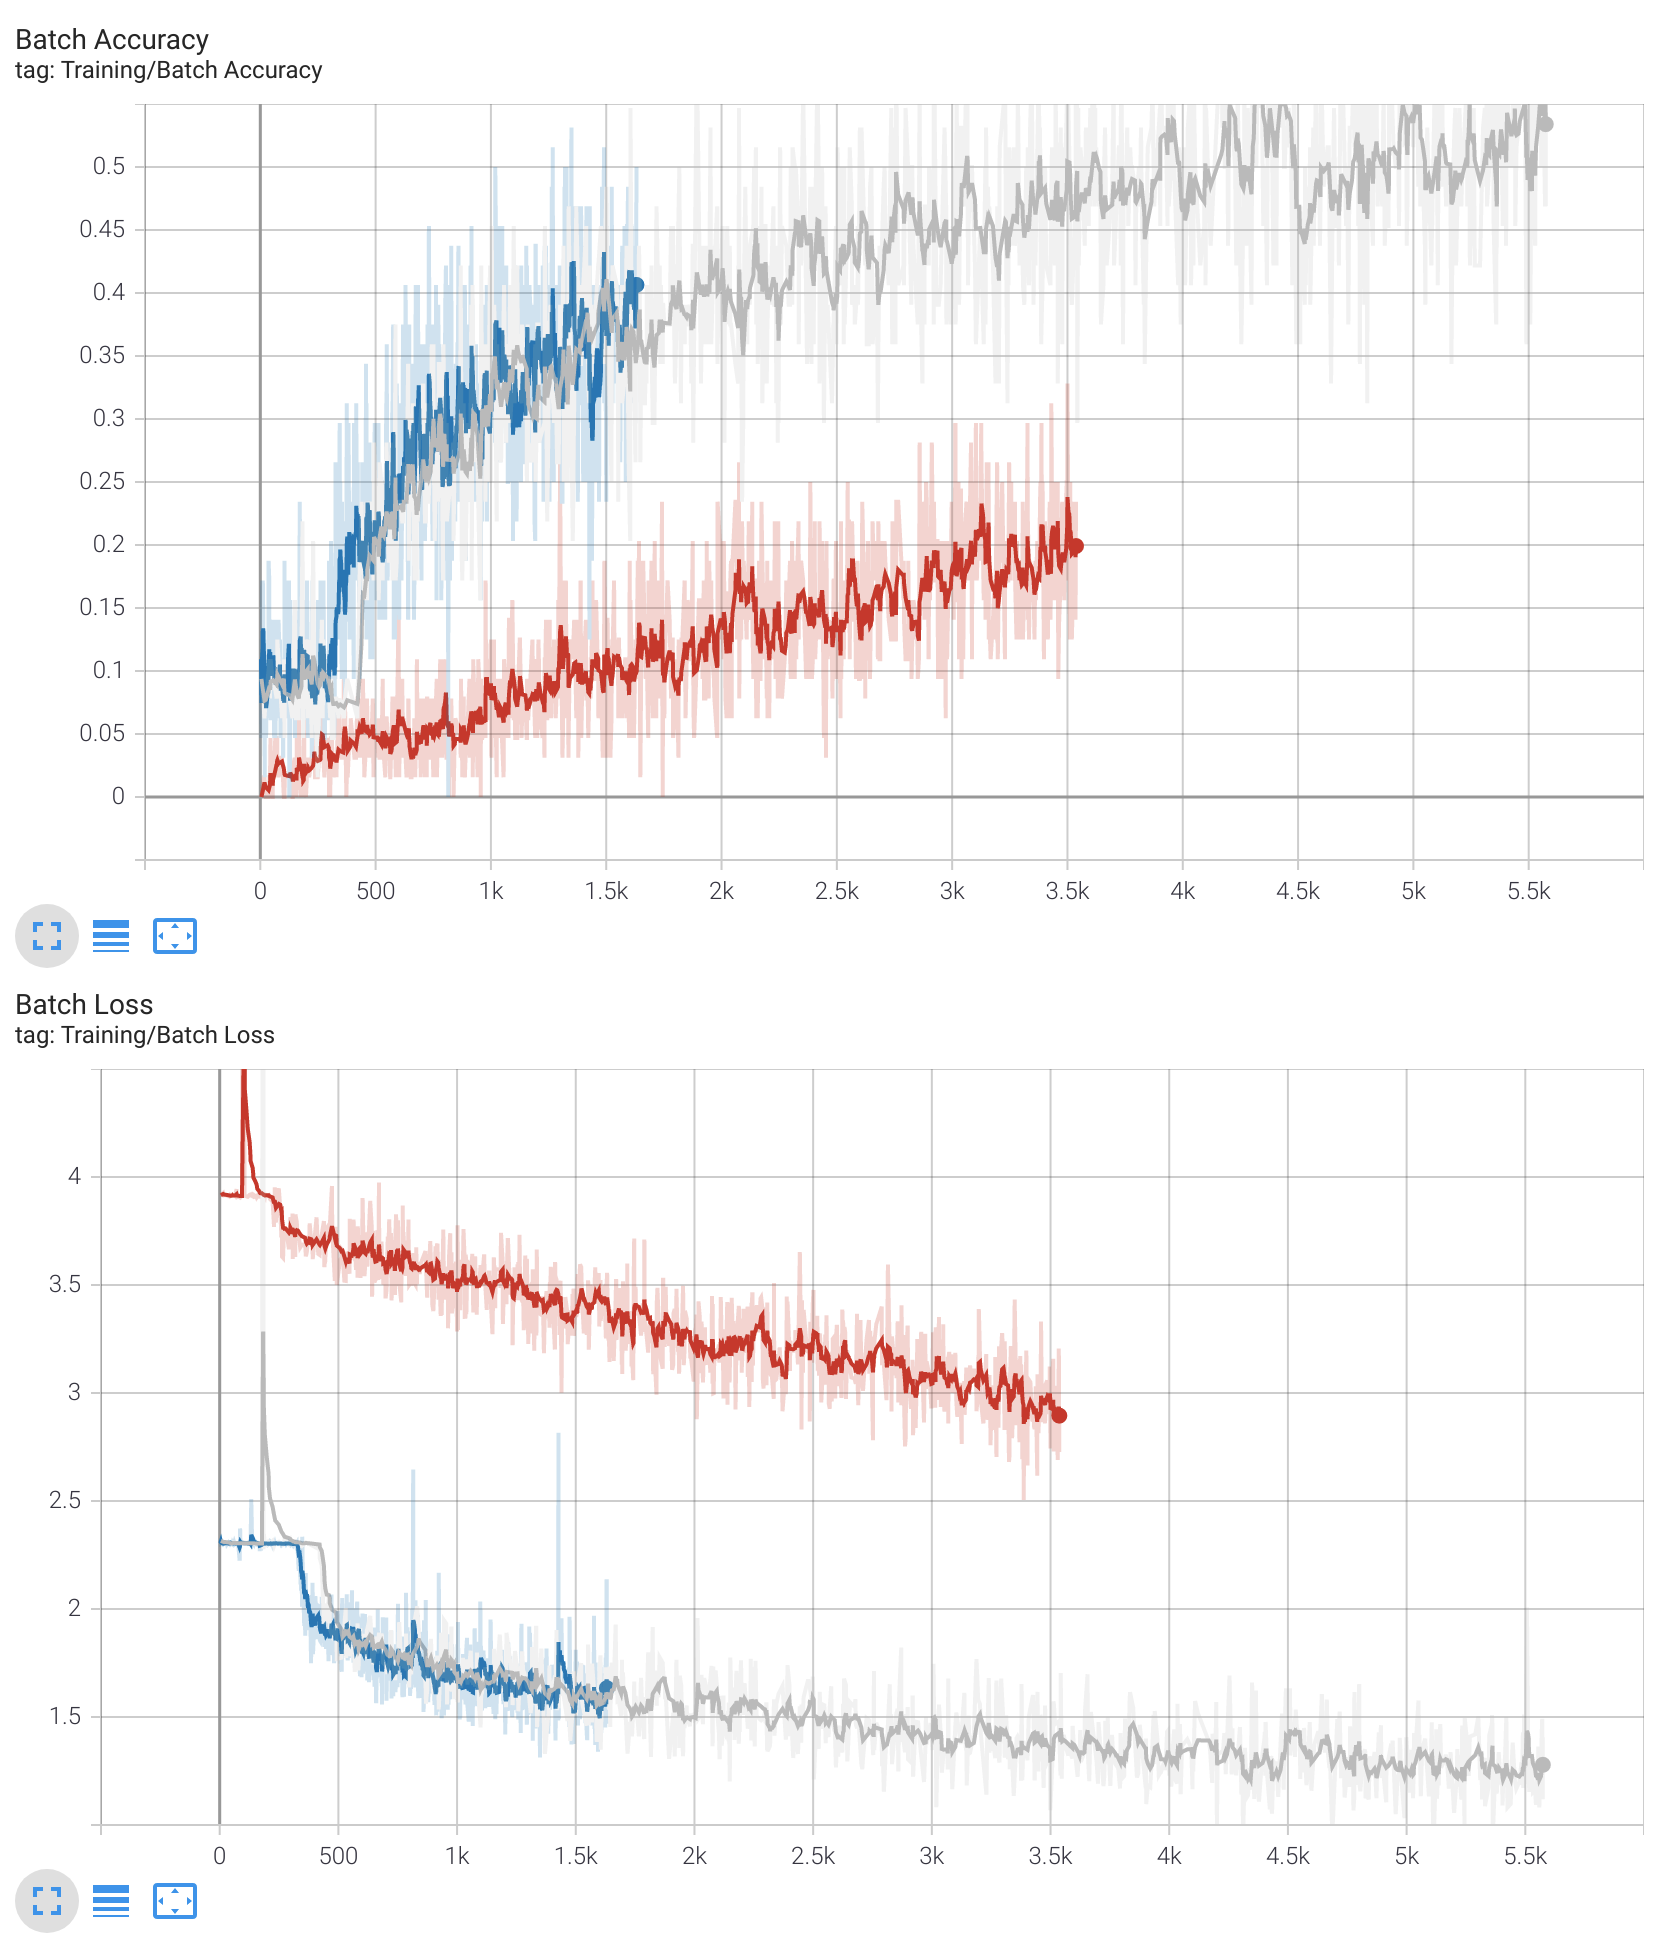
- 고동색 그래프가 착실히 떨어지는 것을 확인할 수 있음

## LR tuning
- 이제는 LR 크기를 늘릴 수 있는 여지를 확인해보도록 하겠음
- 지금은 LR=0.0003이지만 이걸 0.0001씩 늘려서 확인해봄

### lr=0.0004
- run_name: `2021-06-15-15-04-10_FiftyClass-LRTest_LR0.000400_BS064_WORKERS16_EPOCHS200_GPU`
- 시작점이 클래스 20개 기준으로 3.9 언저리이다. 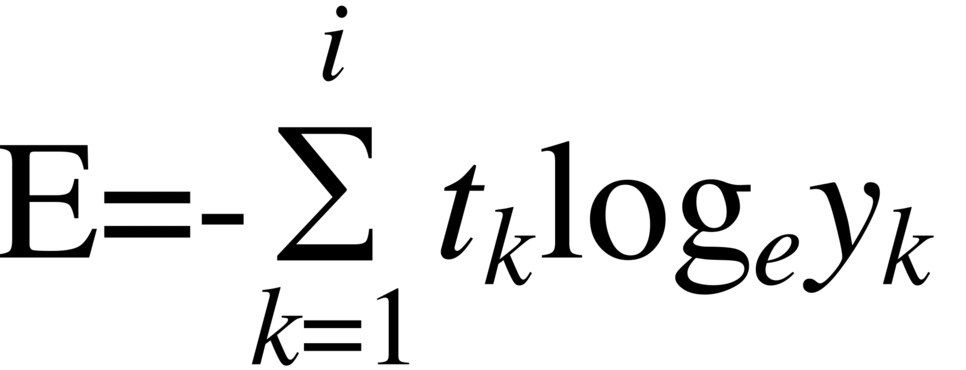
이는 CE Loss에서 모든 값이 동일할 경우 그 값을 모두 합친 값으로 나오기 때문이다.
- 그리고 이 시작점을 "넘어서는" 값들을 가질 경우는 Gradient explosion이라고 생각할 수 있을 것이다.
- lr=0.0004를 기점으로는 잘 학습이 되지 않는다. (Epoch 2가 끝날 때쯤 NaN이 떠서 죽어버렸다...)

- 결론: LR은 0.0003이 가장 적절한 것 같다.

# Full dataset training
- run_name: `2021-06-15-15-09-45_FullDataset_LR0.000300_BS064_WORKERS16_EPOCHS200_GPU`
- Loss 시작점: `6.911`, 약 5에폭 정도는 대기할 수 있을 듯하다.

# Result and Visualization
- 22에폭까지 저장된 `.checkpoints/2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip`를 가지고 visualization을 수행한다. (3번 과정에서 잘 학습되지 않음에 의한 조치임)

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import IPython

from PIL import Image, ImageDraw
from random import randrange
    
from torchvision.ops import nms

import torchvision.transforms
from torchvision.transforms import *
from pretrainer.dataset import LabelReader, ImageNet

labels = LabelReader(label_file_path='pretrainer/label.list').load_label()
valid_dataset = ImageNet(
    labels=labels,
    root_dir='/media/jungin500/windows-10/Dataset/ILSVRC/Data/CLS-LOC/val-sub',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ]),
    classes=1000
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


레이블 파일 읽기 작업:   0%|          | 0/1000 [00:00<?, ?it/s]

레이블 파일 읽기 완료: 총 1000개 레이블 검색


이미지 파일 리스트 읽기 작업:   0%|          | 0/1000 [00:00<?, ?it/s]

총 50000개 이미지 리스트 데이터 및 실효 레이블 1000개 로드 성공


In [22]:
from maintrainer.loss import YoloLoss
from model import YOLOv1, YOLOv1Pretrainer
import random
import os

# PRETRAINED_WEIGHT = r'C:\Workspace\study-projects\yolov1-torch\prepare-torch\.pretrained\2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'
PRETRAINED_WEIGHT = '.checkpoints/2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'

if not os.path.isfile(PRETRAINED_WEIGHT):
    print("Pretrained weight file %s not found!" % args.pretrained)
    exit(-1)

checkpoint = torch.load(PRETRAINED_WEIGHT)
# c_epoch = checkpoint['epoch'] + 1
c_model_state_dict = checkpoint['model_state_dict']
# c_optimizer_state_dict = checkpoint['optimizer_state_dict']
# c_loss = checkpoint['loss']

model = YOLOv1Pretrainer(classes=1000)
model.load_state_dict(c_model_state_dict)

<All keys matched successfully>

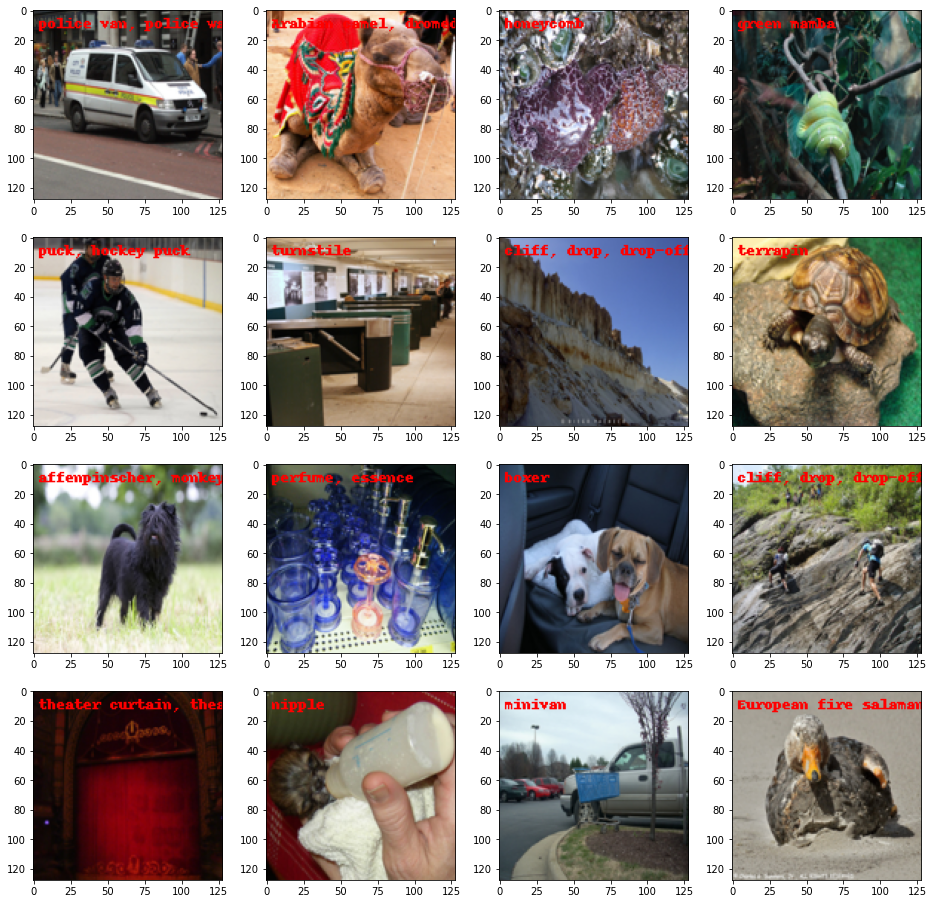

In [32]:
%matplotlib inline
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from IPython import display
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

inline_transform = transforms.Normalize(
    mean=[0.4547857, 0.4349471, 0.40525291],
    std=[0.12003352, 0.12323549, 0.1392444]
)

model.eval()
model = model.cuda()
with torch.no_grad():
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True, drop_last=False)
    for i, (image, label) in enumerate(test_dataloader):
        if i >= 16:
            break
            
        np_image = (np.transpose(image.squeeze().numpy(), (1, 2, 0)) * 255).astype(np.uint8)
        np_label = label.numpy()
        pil_image = Image.fromarray(np_image).resize((128, 128))
        
        output = model(inline_transform(image).cuda())
        cpu_output = torch.argmax(output).cpu().numpy().squeeze()
        
        draw = ImageDraw.Draw(pil_image)
        draw.text((4, 4), list(labels.values())[cpu_output.item()], (255,0,0))
        axs[i // 4, i % 4].imshow(np.asarray(pil_image))
        # axs[i].imshow(np.asarray(pil_image))
        
plt.show()


# Conclusion
- 실제 Validation set에서의 Top-1 61.6%, Top-5 83.2%의 성능을 확인할 수 있었다.
- 이제 문제는 Loss나 Optimizer 등에서 발생하는 것 같다..